# GLUED Analysis

The Global Longitudinal University Enrollment Dataset (GLUED) provides an unbalanced panel dataset of 
estimated enrollment in roughly 17,000 universities in 194 countries and territories worldwide. Variables include 
country, university name, founding year, fields of study, degrees offered, and estimated student enrollments from 
1950 to 2020 in 5-year increments.

This analysis explores the GLUED data set and targets the post-aparteid expansion of South Africa. Later, it examines the relationship between global university enrollment and GDP over the last 65 years. 

## Imports and Data Cleansing

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
enrollments_url = r"https://raw.githubusercontent.com/cbshuang/cbds-take-home/main/enrollments.csv" 
gdp_url = r"https://raw.githubusercontent.com/cbshuang/cbds-take-home/main/Countries%20GDP%201960-2020.csv"

enrollments_df = pd.read_csv(enrollments_url)
gdp_df = pd.read_csv(gdp_url) 

/var/folders/0q/35tyq0m91fd57yvctygqq57c0000gn/T/ipykernel_61225/187963940.py:4: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  enrollments_df = pd.read_csv(enrollments_url)


In [3]:
enrollments_df

,country,countrycode,region,incomegroup,iau_id,iau_id1,eng_name,orig_name,foundedyr,yrclosed,...,divisions,total_fields,unique_fields,specialized,merger,noiau,year,students5_interpolated,students5_extrapolated,students5_estimated
0,"argentina""",ARG,Latin America and Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"italy""",ITA,Europe and Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"peru""",PER,Latin America and Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"peru""",PER,Latin America and Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"romania""",ROU,Europe and Central Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161555,philippines,PHL,East Asia and Pacific,Lower middle income,��IAU-015671��,��IAU-015671��-1,Southwestern University,NaN,1946.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,2020.0,NaN,11468.0,11468.0
161556,philippines,PHL,East Asia and Pacific,Lower middle income,��IAU-015671��,��IAU-015671��-1,Southwestern University,NaN,1946.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,1995.0,11521.0,11521.0,11521.0
161557,philippines,PHL,East Asia and Pacific,Lower middle income,��IAU-015671��,��IAU-015671��-1,Southwestern University,NaN,1946.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,1990.0,12626.0,12626.0,12626.0
161558,philippines,PHL,East Asia and Pacific,Lower middle income,��IAU-015671��,��IAU-015671��-1,Southwestern University,NaN,1946.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,1980.0,12856.0,12856.0,12856.0


In [4]:
id_cols = ["iau_id", "iau_id1"]

bad_chars = r"[^\w\-]" #keep alphanum, underscores, and dashes, remove encoding errors and quotes

#clean both id cols
enrollments_df[id_cols] = (enrollments_df[id_cols]
                           .astype("string")
                           .fillna("")
                           .apply(lambda s: s.str.replace(bad_chars, "", regex = True)
                                  .str.strip()
                                  .str.upper())
)

#change year to int dtype for calcs/plotting and create students_enrolled col based on estimated enrollment
enrollments_df["year"] = pd.to_numeric(enrollments_df["year"], errors = "coerce").astype("Int64")
enrollments_df["students_enrolled"] = pd.to_numeric(enrollments_df["students5_estimated"], errors = "coerce").astype("Int64")


#Basic shape/dupe checks
print("Shape: ", enrollments_df.shape)
print("Null percentage in students_enrolled column: ", enrollments_df["students_enrolled"].isna().sum()/len(enrollments_df)*100.0)

Shape:  (161560, 28)
Null percentage in students_enrolled column:  11.600024758603615


In [5]:
#keep only columns that are relevant to our analysis
keep_cols = ["iau_id1", "iau_id", "country", "countrycode", "region", "incomegroup", "year", "students_enrolled"]

#much of our analysis will be time-based, so we'll drop nulls on year
enrollment = enrollments_df[keep_cols].dropna(subset = ["year"]) 

In [6]:
enrollment #looks good!

,iau_id1,iau_id,country,countrycode,region,incomegroup,year,students_enrolled
7,GLUE-100-1,GLUE-100,brazil,BRA,Latin America and Caribbean,Upper middle income,1995,16176
8,GLUE-100-1,GLUE-100,brazil,BRA,Latin America and Caribbean,Upper middle income,2000,18136
9,GLUE-100-1,GLUE-100,brazil,BRA,Latin America and Caribbean,Upper middle income,1990,18702
10,GLUE-100-1,GLUE-100,brazil,BRA,Latin America and Caribbean,Upper middle income,2005,19611
11,GLUE-100-1,GLUE-100,brazil,BRA,Latin America and Caribbean,Upper middle income,1985,20979
...,...,...,...,...,...,...,...,...
161555,IAU-015671-1,IAU-015671,philippines,PHL,East Asia and Pacific,Lower middle income,2020,11468
161556,IAU-015671-1,IAU-015671,philippines,PHL,East Asia and Pacific,Lower middle income,1995,11521
161557,IAU-015671-1,IAU-015671,philippines,PHL,East Asia and Pacific,Lower middle income,1990,12626
161558,IAU-015671-1,IAU-015671,philippines,PHL,East Asia and Pacific,Lower middle income,1980,12856


## Exploratory Data Analysis

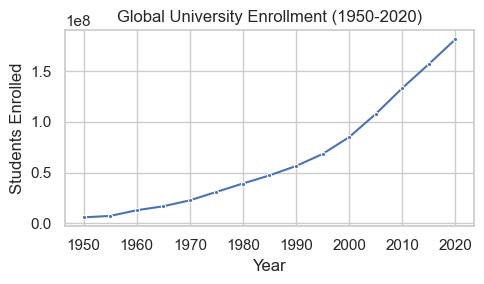

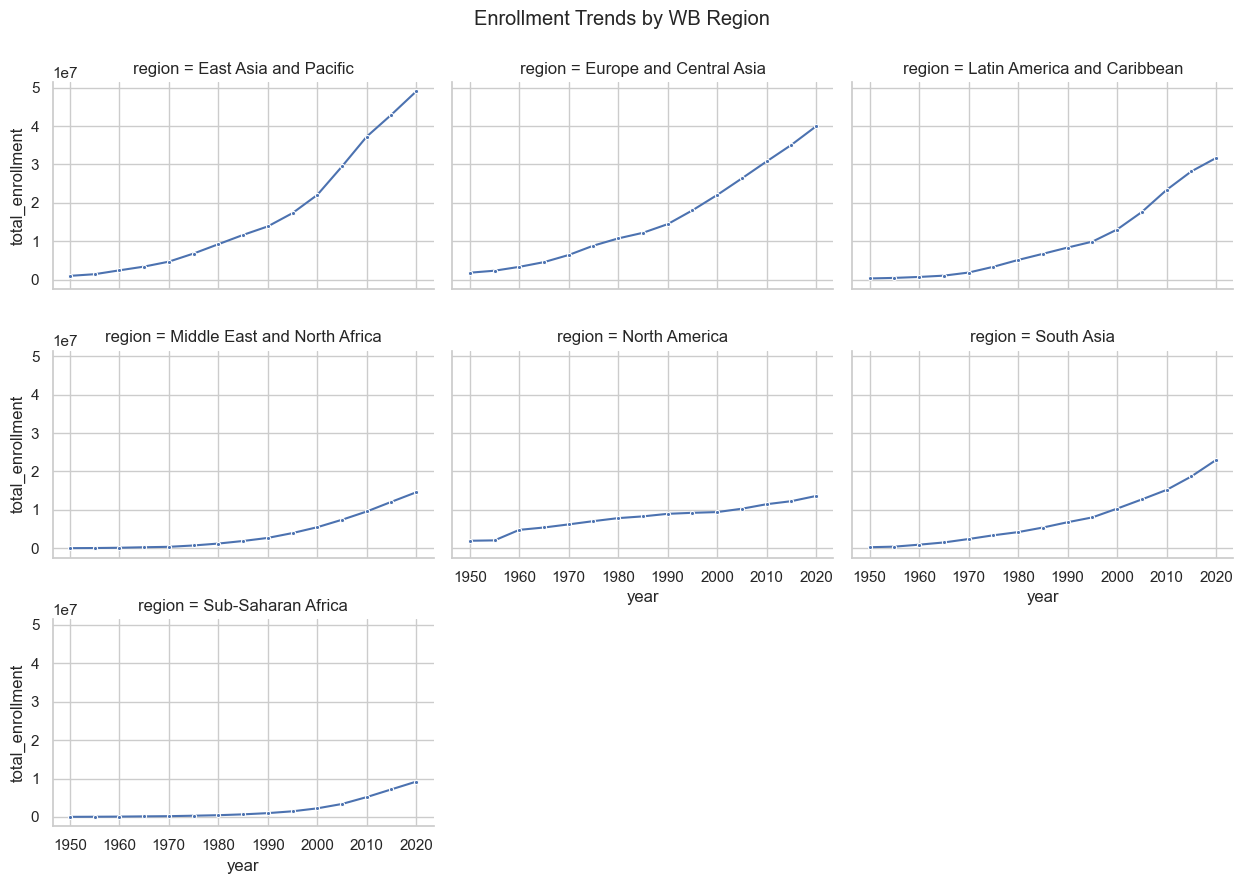

       students_enrolled
count           142819.0
mean         6804.205988
std         24359.439568
min                  0.0
10%                490.0
25%               1148.0
50%               2705.0
75%               6492.0
90%              14533.2
max            2673333.0


In [7]:
sns.set_theme(style = "whitegrid")

#Global trends
#total enrolled by year
global_trends = enrollment.groupby("year", as_index = False).agg(total_enrollment = ("students_enrolled", "sum")) 

#plot for global enrollment trends
plt.figure(figsize = (5, 3))
sns.lineplot(data = global_trends, x = "year", y = "total_enrollment", marker = ".")
plt.title("Global University Enrollment (1950-2020)")
plt.xlabel("Year")
plt.ylabel("Students Enrolled")
plt.tight_layout()
plt.show()


#Regional trends
regional_trends = enrollment.groupby(["region", "year"], as_index = False).agg(total_enrollment = ("students_enrolled", "sum"))

p = sns.relplot(data = regional_trends,
                x = "year", y = "total_enrollment",
                col = "region", col_wrap = 3,
                kind = "line",
                height = 3, aspect = 1.4, marker = ".")
p.fig.subplots_adjust(top = 0.9)
p.fig.suptitle("Enrollment Trends by WB Region")
plt.show()


#summary stats table
summary = (enrollment[["students_enrolled"]].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))
print(summary)


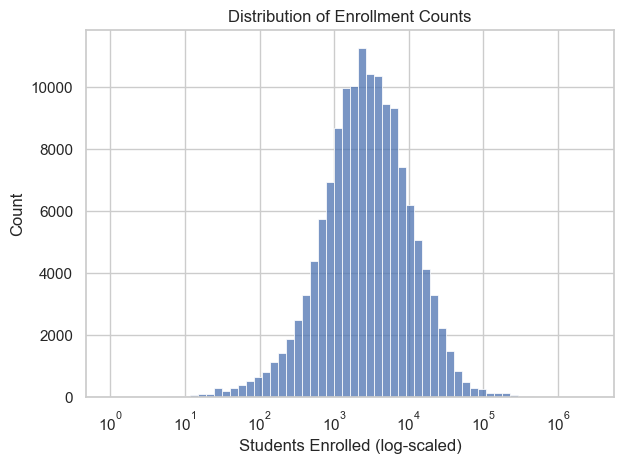

In [8]:
#Overall distribution of enrollment counts
sns.histplot(enrollment["students_enrolled"], bins = 60, log_scale = True)

plt.title("Distribution of Enrollment Counts")
plt.xlabel("Students Enrolled (log-scaled)")
plt.tight_layout()
plt.show()

### Countries with Fastest YoY Enrollment Growth 

The code below uses Compound Annual Growth Rate (CAGR) to find year-over-year growth, and plots the top 10 fastest-growing countries. 

CAGR finds the mean growth rate over a time period for compounding values like population. 

Sources:
* https://en.wikipedia.org/wiki/Compound_annual_growth_rate
* https://feliperego.github.io/blog/2016/08/10/CAGR-Function-In-Python
* https://dabure.com/blog/calculating-cagr-in-pandas
* https://q-viper.github.io/html_posts/python-for-stock-market-analysis-growth-rates.html

/var/folders/0q/35tyq0m91fd57yvctygqq57c0000gn/T/ipykernel_61225/4110720809.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_cagr)
/var/folders/0q/35tyq0m91fd57yvctygqq57c0000gn/T/ipykernel_61225/4110720809.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = top10growth, x = "CAGR", y = "country", palette = "mako", orient = "h")


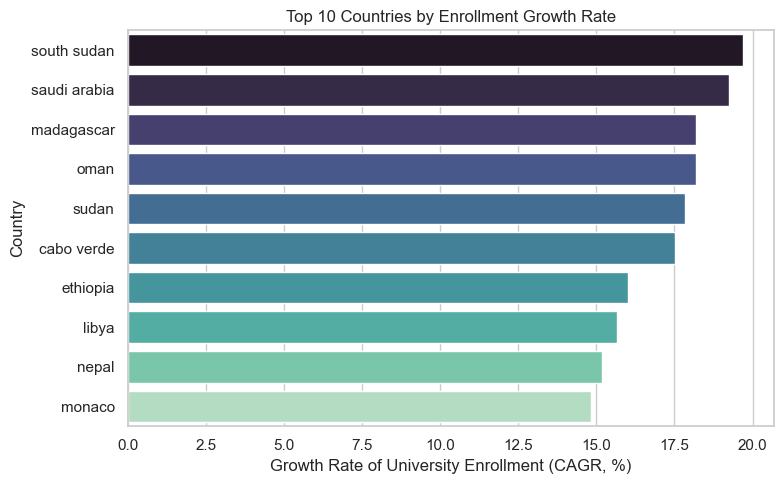

In [9]:
#Top countries by growth (compound annual growth rate [CAGR])

#agg country-year totals
country_year = enrollment.groupby(["country", "year"], as_index = False).agg(total_enrollment = ("students_enrolled", "sum"))

def calculate_cagr(group):
    #remove missing/zero
    g = group.dropna(subset = ["total_enrollment"])
    g = g[g["total_enrollment"] > 0]
    if g.empty: 
        return np.nan
    
    y0, yN = g["year"].iloc[0], g["year"].iloc[-1] #start and end years
    v0, vN = g["total_enrollment"].iloc[0], g["total_enrollment"].iloc[-1] #start and end enrollments

    years = yN - y0

    if years == 0 or v0 == 0: #avoid trivial spans and div by 0 error
        return np.nan
    
    return ((vN / v0) ** (1 / years) - 1) * 100.0 #atypical but formats as %

growth = (country_year
          .sort_values("year")
          .groupby("country")
          .apply(calculate_cagr)
          .rename("CAGR")
          .dropna()
          .reset_index()
)

top10growth = growth.nlargest(10, "CAGR").sort_values("CAGR", ascending = False)

plt.figure(figsize=(8, 5))
sns.barplot(data = top10growth, x = "CAGR", y = "country", palette = "mako", orient = "h")
plt.xlabel("Growth Rate of University Enrollment (CAGR, %)")
plt.ylabel("Country")
plt.title("Top 10 Countries by Enrollment Growth Rate")
plt.tight_layout()
plt.show()

## Difference-in-Differences Analysis of South African Post-Apartheid Expansion

In 2015, I spent 6 months living in South Africa through a study abroad program. While there, I was privileged to witness the beginning of the FeesMustFall movement, which protested against ever-rising university tuition fees and the colonization of curricula and campuses across the nation. The movement ultimately brought about a revised tuition structure for public universities, making higher education more attainable for millions of young people. 

https://www.globalcitizen.org/en/content/south-africa-student-protests-explained/

I saw firsthand the power of students advocating for themselves, and the need for affordable, equitable education. Just 20 years prior, South Africa held its first election that was open to all citizens, making the end of Apartheid. Many of the students leading FeesMustFall were born during this transformative period. 

Inspired by these events, the following analysis examines the 30-year period before and after the 1994 South African General Election, and attempts to find a causal relationship between the election and university enrollment. We will use Difference-in-Differences to compare enrollments during this period between South African universities and those in other Sub-Saharan African countries. 


Sources:

* https://www.kaggle.com/code/harrywang/difference-in-differences-in-python
* https://luis-alberto-g-efe.medium.com/practical-econometrics-difference-in-differences-multiple-groups-and-periods-in-python-fixed-40bd0d04f734
* https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html
* https://medium.com/@patthie/the-great-regression-with-python-difference-in-difference-regressions-c2e8ac980857





In [10]:
#Define variables
pre_start = 1980
post_end = 2010 #30-year analysis window around 1994; parliamentary terms are 5yrs in ZA
event_year = 1994 #year of first open election
treatment_country = "south africa" 
control_region = "Sub-Saharan Africa"

df = enrollment.copy()


#Build treatment and control

#Treatment: colleges/universities located in South Africa
df["SA"] = (df["country"] == treatment_country).fillna(0).astype(int)

#Control: other Sub-Saharan African countries
df["control"] = ((df["region"] == control_region) & (df["SA"] == 0))

#Keep only South Africa and control countries and filter by our 30-year window
df = df.loc[((df["SA"] == 1) | (df["control"])) & (df["year"].between(pre_start, post_end))]

#Post if after year of election
df["post"] = (df["year"] > event_year).fillna(0).astype(int)

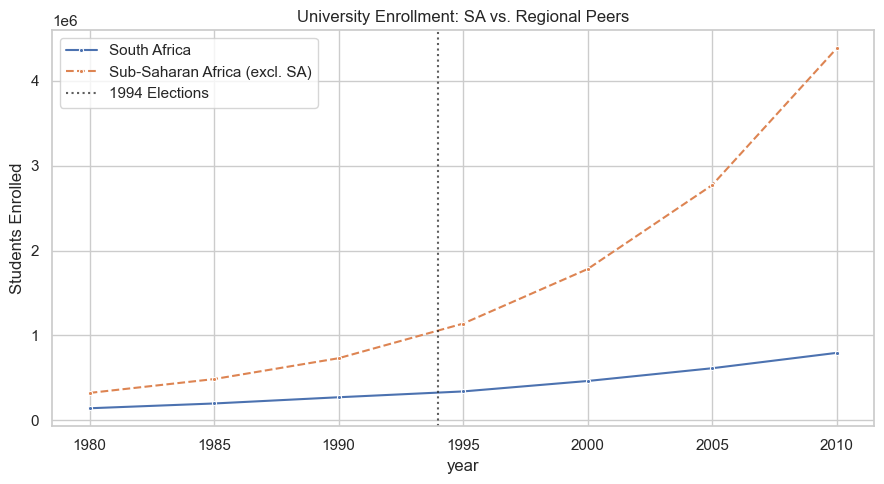

In [11]:
#Basic plot of enrollment trends of SA and non-SA Sub Sahara
trend = df.groupby(["SA", "year"], as_index=False).agg(total_enroll=("students_enrolled", "sum"))

plt.figure(figsize=(9, 5))
sns.lineplot(data = trend[trend["SA"] == 1],
             x = "year", y = "total_enroll",
             label = "South Africa", marker = ".")
sns.lineplot(data = trend[trend["SA"] == 0],
             x = "year", y = "total_enroll",
             label = f"{control_region} (excl. SA)", marker = ".", ls = "--")
plt.axvline(event_year, ls = ":", c = "k", alpha = .7,
            label = "1994 Elections")
plt.title("University Enrollment: SA vs. Regional Peers")
plt.ylabel("Students Enrolled")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#Building the DiD model

# Step 0: Select only the columns the regression needs

vars_for_did = ["students_enrolled",  #outcome variable
                "SA",                 #1 if institution is in South Africa
                "post",               #1 if year >= 1995, i.e. after "cause"
                "iau_id1",            #university ID (for clustering)
                "year"]               #calendar year

df_did = df[vars_for_did].dropna().copy()


# Step 1: Convert data types to feed right variables to model

df_did["iau_id1"] = df_did["iau_id1"].astype("category")  #university fixed effects (don't want this to effect model)
df_did["year"] = df_did["year"].astype("category") #year fixed effects, filters out other time-based major events
df_did["SA"] = df_did["SA"].astype(int)       #ensure 0/1 ints
df_did["post"] = df_did["post"].astype(int)


# Step 2: Fit the DiD regression.
#
# Formula:  outcome ~ SA:post + FE_university + FE_year
#
# cov_type = 'cluster' adjusts for within-university correlation

formula = "students_enrolled ~ SA:post + C(iau_id1) + C(year)"

model = (
    smf.ols(formula, data = df_did)
        .fit(cov_type = "cluster",
             cov_kwds = {"groups": df_did["iau_id1"]})  # cluster id
)


# Step 3: Print the regression table

print(model.summary())

 
# Step 4: Pull out the DiD coefficient (estimated effect) and
#           compute a 95% confidence interval.

b3 = model.params["SA:post"] #point estimate (β₃)
serr = model.bse["SA:post"] #standard error
ciL = b3 - 1.96 * serr #lower bound
ciU = b3 + 1.96 * serr #upper bound

print(f"\nDiD estimate (β₃)  = {b3} students")
print(f"95% CI = [{ciL} , {ciU}]")

/Users/maxbicking/Desktop/cb-take-home/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1156, but rank is 7
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:      students_enrolled   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                -5.801e+11
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               1.00
Time:                        12:16:36   Log-Likelihood:                -38408.
No. Observations:                3976   AIC:                         7.913e+04
Df Residuals:                    2819   BIC:                         8.641e+04
Df Model:                        1156                                         
Covariance Type:              cluster                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

### Summary

* Post-apartheid reforms are associated with an estimated ~ 7,700 students per South-African university per year 
* A 95% confidence interval is wide and crosses 0. 
* While our DiD estimate is large, the confidence interval suggests that the effect is not statistically significant at the 95% confidence level. In the future, we could examine finer-grained data or pick a different control group.


## GDP Analysis

In [13]:
gdp_df #imported earlier

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Africa Eastern and Southern,AFE,1.931311e+10,1.972349e+10,2.149392e+10,2.573321e+10,2.352744e+10,2.681057e+10,2.915216e+10,3.017317e+10,...,9.430000e+11,9.510000e+11,9.640000e+11,9.850000e+11,9.200000e+11,8.730000e+11,9.850000e+11,1.010000e+12,1.010000e+12,9.210000e+11
1,Africa Western and Central,AFW,1.040428e+10,1.112805e+10,1.194335e+10,1.267652e+10,1.383858e+10,1.486247e+10,1.583285e+10,1.442643e+10,...,6.710000e+11,7.280000e+11,8.210000e+11,8.650000e+11,7.610000e+11,6.910000e+11,6.840000e+11,7.420000e+11,7.950000e+11,7.850000e+11
2,Australia,AUS,1.860679e+10,1.968306e+10,1.992272e+10,2.153993e+10,2.380110e+10,2.597715e+10,2.730989e+10,3.044462e+10,...,1.400000e+12,1.550000e+12,1.580000e+12,1.470000e+12,1.350000e+12,1.210000e+12,1.330000e+12,1.430000e+12,1.390000e+12,1.330000e+12
3,Austria,AUT,6.592694e+09,7.311750e+09,7.756110e+09,8.374175e+09,9.169984e+09,9.994071e+09,1.088768e+10,1.157943e+10,...,4.310000e+11,4.090000e+11,4.300000e+11,4.420000e+11,3.820000e+11,3.960000e+11,4.160000e+11,4.550000e+11,4.450000e+11,4.330000e+11
4,Burundi,BDI,1.960000e+08,2.030000e+08,2.135000e+08,2.327500e+08,2.607500e+08,1.589950e+08,1.654446e+08,1.782971e+08,...,2.235821e+09,2.333308e+09,2.451625e+09,2.705783e+09,3.104395e+09,2.732809e+09,2.748180e+09,2.668496e+09,2.631434e+09,2.841786e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,St. Vincent and the Grenadines,VCT,1.306656e+07,1.399988e+07,1.452488e+07,1.370822e+07,1.475821e+07,1.510821e+07,1.609987e+07,1.583518e+07,...,6.761296e+08,6.929333e+08,7.212074e+08,7.277148e+08,7.554000e+08,7.744296e+08,7.921778e+08,8.113000e+08,8.250407e+08,8.074741e+08
116,World,WLD,1.390000e+12,1.440000e+12,1.550000e+12,1.670000e+12,1.820000e+12,1.990000e+12,2.160000e+12,2.290000e+12,...,7.370000e+13,7.530000e+13,7.740000e+13,7.960000e+13,7.510000e+13,7.630000e+13,8.120000e+13,8.630000e+13,8.760000e+13,8.470000e+13
117,South Africa,ZAF,7.575397e+09,7.972997e+09,8.497997e+09,9.423396e+09,1.037400e+10,1.133440e+10,1.235500e+10,1.377739e+10,...,4.580000e+11,4.340000e+11,4.010000e+11,3.810000e+11,3.470000e+11,3.240000e+11,3.810000e+11,4.050000e+11,3.880000e+11,3.350000e+11
118,Zambia,ZMB,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,1.264286e+09,1.368000e+09,...,2.345952e+10,2.550306e+10,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631159e+10,2.330867e+10,1.811063e+10


In [14]:
#For ease of country/year analysis with GDP df, we will start by transforming the enrollments df to agg by country/year
enrollment_cy = enrollment.groupby(["countrycode", "year"], as_index = False).agg(total_enrollment = ("students_enrolled", "sum"))

#id vars = country name, country code
#value vars is everything else
id_vars = ["Country Name", "Country Code"]
value_vars = list(gdp_df.select_dtypes('number'))

#pivot (melt) columns in gdp csv so that each country has a new row for every year with the year and gdp 
gdp_pivoted = gdp_df.melt(id_vars = id_vars, 
                          value_vars = value_vars, 
                          var_name = "year", value_name = "GDP_IN_BILLIONS").rename(columns = {"Country Code": "countrycode"})

#ensure datatypes are usable for plotting etc.
gdp_pivoted["year"] = gdp_pivoted["year"].astype(int)
gdp_pivoted["GDP_IN_BILLIONS"] = pd.to_numeric(gdp_pivoted["GDP_IN_BILLIONS"], errors = "coerce")

#merge gdp to enrollment on country code and year, and get rid of nulls
merged = pd.merge(enrollment_cy, gdp_pivoted, on = ["countrycode", "year"]).dropna(subset = ["total_enrollment", "GDP_IN_BILLIONS"])


merged

,countrycode,year,total_enrollment,Country Name,GDP_IN_BILLIONS
0,AUS,1960,75865,Australia,1.860679e+10
1,AUS,1965,126957,Australia,2.597715e+10
2,AUS,1970,184147,Australia,4.133722e+10
3,AUS,1975,237631,Australia,9.733306e+10
4,AUS,1980,268443,Australia,1.500000e+11
...,...,...,...,...,...
1055,ZWE,2000,36491,Zimbabwe,6.689958e+09
1056,ZWE,2005,59433,Zimbabwe,5.755215e+09
1057,ZWE,2010,68555,Zimbabwe,1.204166e+10
1058,ZWE,2015,79949,Zimbabwe,1.996312e+10


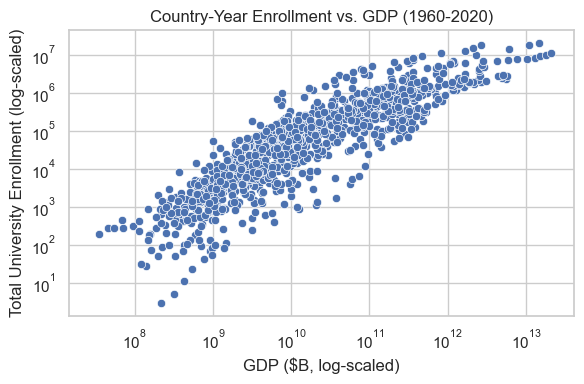

Pearson Coefficient (r):  0.678176267308087
R Squared:  0.45992304953992985


In [15]:
#Basic plot of enrollment vs. GDP
plt.figure(figsize=(6, 4))
sns.scatterplot(data = merged, x = "GDP_IN_BILLIONS", y = "total_enrollment")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("GDP ($B, log-scaled)")
plt.ylabel("Total University Enrollment (log-scaled)")
plt.title("Country-Year Enrollment vs. GDP (1960-2020)")
plt.tight_layout()
plt.show()


#Pearson coef to see strength of correlation
pearson_coef  = merged["GDP_IN_BILLIONS"].corr(merged["total_enrollment"], method = "pearson")

print(f"Pearson Coefficient (r): ", pearson_coef)
print(f"R Squared: ", pearson_coef ** 2)

### Summary

* GDP and university enrollment have a moderately strong, positive relationship.
* Pearson correlation is 0.68, meaning larger economies tend to support larger student bodies.
* R squared indicates that GDP alone explains roughly 46% of the year-to-year, country-to-country variation in enrollment.

## Conclusions

This analysis explored 70 years of global growth in higher education. It examined how structural force like demographics, economics, and policy, interact to shape access and equity to colleges and universities. Three major takeaways:

1. Global expansion happened quickly, but is variable accross different geographic regions.

2. Major policy decisions play a role in educational access. Their effects, however, might be slower or more subtle to realize.

3. GDP is a meaningful indicator of countries' capacity to educate students. More granular data, and more data sources, may be needed for a better picture. 


**Next Steps**

* Include additional economic indicators, such as UN, OECD, and IMF, to gain a more comprehensive economic model.
* Analyze data by clusters. Most obvious first pass would be by WB economic class, but could emplpoy unsuervised learning techniques for unbiased clustering approach. 
* Normalize enrollment for population.

Overall, the data show that economic growth and higher education opportunity are tightly linked, but more data sources may be needed to fully understand the impact of economic changes and policy shifts. 
